# **Weather Time Series Forecasting**

## Introduction
Weather affects everything from daily decisions about what to wear to the planning of significant events. Accurate forecasting is crucial for safety, agriculture, aviation, and disaster preparedness. But how do we predict what nature has in store?

## The Role of Machine Learning
Traditional weather forecasting relies on complex physics-based models to simulate atmospheric conditions. While these models are effective, they can be slow and sometimes lack the precision needed for local predictions. Enter machine learning: by analyzing vast amounts of weather data, it can detect patterns that even the most sophisticated traditional models might miss, allowing for more accurate and localized forecasts.

## Time Series Forecasting
Time series forecasting, a key machine learning technique, uses historical data to predict future events. By examining past weather patterns, it helps anticipate changes in temperature, wind, and other variables. This method transforms vast amounts of historical data into insights about future conditions, making it an invaluable tool for meteorologists and data scientists alike.

## Project Overview
In this project, we dive deep into weather data from May 2023 to July 2024, focusing on daily temperature highs and lows across nine major cities. Using Ridge regression, a robust machine learning algorithm, we aim to predict future temperatures and uncover the key factors influencing these changes.

Join me on this exploration of weather patterns as we use data science to decode the natural world. By the end of this journey, we will have not only predicted the weather but also deepened our understanding of the forces shaping our environment.

**Let's begin**.

<div class="alert alert-block alert-info">
<b>Data Limitations:</b> The dataset is limited to about a year of weather and 9 locations
</div>

## **Import Libraries and Data**
Before we dive into the data, we need to gather our tools. In data science, this means importing the necessary libraries and loading our dataset. These libraries streamline complex tasks, making data manipulation, analysis, and visualization much more manageable.

**Why These Libraries?**
- **Pandas**: A powerful library for managing and manipulating large datasets efficiently.
- **Statsmodels and Scikit-Learn**: Our primary libraries for statistical analysis and machine learning, providing robust tools for building and evaluating forecasting models.
- **Matplotlib and Seaborn**: Essential for data visualization, these libraries help us quickly identify trends and patterns within our data.

In [3]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Statistical Analysis
import statsmodels.api as sm
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

# Machine Learning
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge

# Define seaborn color palette for plots
color_pal = sns.color_palette()

# Read the CSV file into a Pandas DataFrame.
# Ensure the 'datetime' column is parsed as datetime type.
data = pd.read_csv("Weather_data_2023_2024.csv")
data['datetime'] = pd.to_datetime(data['datetime'])

# Set a multi-level index with 'location' and 'datetime'.
df = data.set_index(['location', 'datetime'])


## **Data Exploration**
### Building a Strong Foundation for Accurate Forecasting
Data exploration is a crucial step in understanding the characteristics and patterns of our dataset. It allows us to identify potential issues and prepare our data for modeling. In this phase, we will:

- **Identify Trends and Seasonality**: Examine the data to uncover recurring patterns and seasonal variations that are critical for time series forecasting.
- **Detect Outliers and Handle Missing Values**: Ensure data quality by identifying anomalies and filling gaps, preventing skewed results and inaccuracies in our models.
- **Assess Feature Relationships**: Analyze correlations among variables to understand dependencies and inform feature selection, ensuring that we include the most predictive attributes.

A thorough exploration lays the groundwork for building reliable and accurate forecasting models by ensuring that our data is clean, consistent, and insightful.

### Visualizing Temperature Trends
To get an initial understanding of our target variables, tempmax and tempmin, we plot them over time to observe their distribution and any evident patterns.

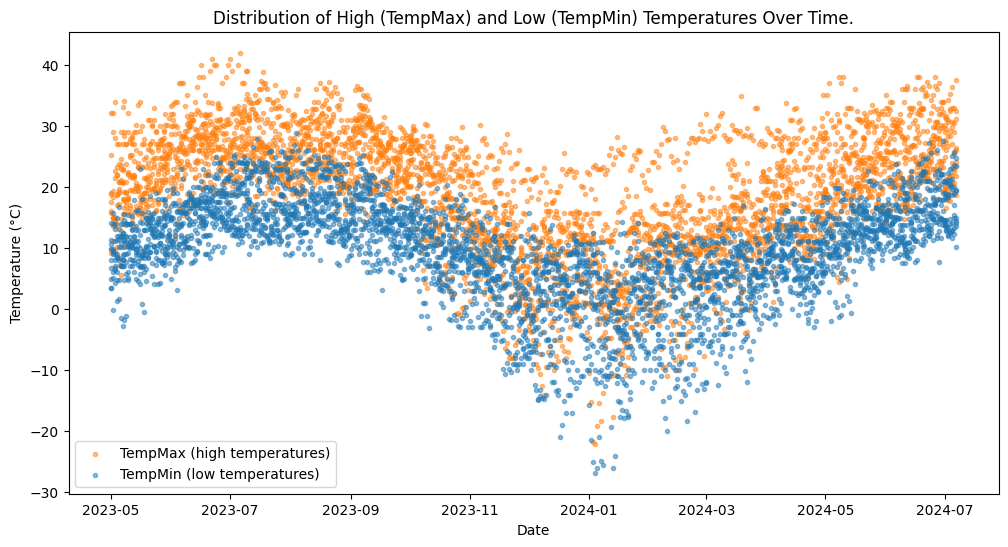

In [4]:
# Plot 'tempmax' and 'tempmin' to visualize the distribution over time.
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting TempMax
ax.scatter(
    df.index.get_level_values('datetime'),
    df['tempmax'],
    color=color_pal[1],
    label='TempMax (high temperatures)',
    alpha=0.5,
    marker='.'
)

# Plotting TempMin
ax.scatter(
    df.index.get_level_values('datetime'),
    df['tempmin'],
    color=color_pal[0],
    label='TempMin (low temperatures)',
    alpha=0.5,
    marker='.'
)

# Add titles and labels.
ax.set_title('Distribution of High (TempMax) and Low (TempMin) Temperatures Over Time.')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend()
plt.show()


### Initial Data Inspection
We begin by inspecting the dataset to check for any initial issues such as duplicate entries or missing values.

In [5]:
# Display the first few rows of the DataFrame to understand the structure and content.
df.head()


tempmax  tempmin  temp  feelslikemax  feelslikemin  \
location datetime                                                         
Beijing  2023-05-01     25.2      8.0  18.1          25.2           8.0   
         2023-05-02     29.0     15.8  22.3          27.9          15.8   
         2023-05-03     28.0     14.0  21.2          27.6          14.0   
         2023-05-04     22.0     15.0  17.8          22.0          15.0   
         2023-05-05     19.0     16.7  17.8          19.0          16.7   

                     feelslike   dew  humidity  precip  precipprob  ...  \
location datetime                                                   ...   
Beijing  2023-05-01       18.1   8.1      54.7     0.0           0  ...   
         2023-05-02       22.1  10.4      48.9     0.0           0  ...   
         2023-05-03       21.1  12.4      59.4     0.0           0  ...   
         2023-05-04       17.8  14.0      79.1     0.1         100  ...   
         2023-05-05       17.8   9.5      61.9     1.1         100  ...   

                     sealevelpressure  cloudcover  visibility  \
location datetime                                               
Beijing  2023-05-01            1009.6        54.2        10.4   
         2023-05-02            1008.3        26.0        10.6   
         2023-05-03            1011.3        62.2        10.1   
         2023-05-04            1009.2        85.1         8.4   
         2023-05-05            1009.1        95.8        11.4   

                                 sunrise               sunset  moonphase  \
location datetime                                                          
Beijing  2023-05-01  2023-05-01T05:15:37  2023-05-01T19:08:22       0.35   
         2023-05-02  2023-05-02T05:14:22  2023-05-02T19:09:22       0.39   
         2023-05-03  2023-05-03T05:13:08  2023-05-03T19:10:22       0.42   
         2023-05-04  2023-05-04T05:11:56  2023-05-04T19:11:22       0.45   
         2023-05-05  2023-05-05T05:10:45  2023-05-05T19:12:22       0.48   

                                 conditions  \
location datetime                             
Beijing  2023-05-01        Partially cloudy   
         2023-05-02        Partially cloudy   
         2023-05-03        Partially cloudy   
         2023-05-04  Rain, Partially cloudy   
         2023-05-05          Rain, Overcast   

                                                           description  \
location datetime                                                        
Beijing  2023-05-01                  Partly cloudy throughout the day.   
         2023-05-02                  Partly cloudy throughout the day.   
         2023-05-03                  Partly cloudy throughout the day.   
         2023-05-04  Partly cloudy throughout the day with late aft...   
         2023-05-05  Cloudy skies throughout the day with rain clea...   

                                  icon          stations  
location datetime                                         
Beijing  2023-05-01  partly-cloudy-day  ZBAA,54511099999  
         2023-05-02  partly-cloudy-day  ZBAA,54511099999  
         2023-05-03  partly-cloudy-day  ZBAA,54511099999  
         2023-05-04               rain  ZBAA,54511099999  
         2023-05-05               rain  ZBAA,54511099999  

[5 rows x 26 columns]

In [6]:
# Display counts of all unique locations in the multi-index to understand the data distribution.
df.index.get_level_values('location').value_counts()


location
Beijing          434
Berlin           434
London           434
Mexico City      434
Moscow           434
Ottawa           434
Paris            434
Rome             434
Washington DC    434
Name: count, dtype: int64

In [7]:
# Check data types of each column to ensure proper data types for processing.
df.dtypes


tempmax             float64
tempmin             float64
temp                float64
feelslikemax        float64
feelslikemin        float64
feelslike           float64
dew                 float64
humidity            float64
precip              float64
precipprob            int64
precipcover         float64
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
sunrise              object
sunset               object
moonphase           float64
conditions           object
description          object
icon                 object
stations             object
dtype: object

In [8]:
# Check for duplicate values in the data to ensure data quality.
df.duplicated().sum()


np.int64(0)

In [9]:
# Display the number of missing values for each column to identify potential issues.
df.isnull().sum()


tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

### Data Cleaning
Based on our initial inspection, we proceed with cleaning the dataset:

In [10]:
# Drop columns that do not contribute to predictive power or are not numerical features.
df = df.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

# Display the updated DataFrame to confirm columns were removed.
df.head()


tempmax  tempmin  temp  feelslikemax  feelslikemin  \
location datetime                                                         
Beijing  2023-05-01     25.2      8.0  18.1          25.2           8.0   
         2023-05-02     29.0     15.8  22.3          27.9          15.8   
         2023-05-03     28.0     14.0  21.2          27.6          14.0   
         2023-05-04     22.0     15.0  17.8          22.0          15.0   
         2023-05-05     19.0     16.7  17.8          19.0          16.7   

                     feelslike   dew  humidity  precip  precipprob  \
location datetime                                                    
Beijing  2023-05-01       18.1   8.1      54.7     0.0           0   
         2023-05-02       22.1  10.4      48.9     0.0           0   
         2023-05-03       21.1  12.4      59.4     0.0           0   
         2023-05-04       17.8  14.0      79.1     0.1         100   
         2023-05-05       17.8   9.5      61.9     1.1         100   

                     precipcover  snow  snowdepth  windgust  windspeed  \
location datetime                                                        
Beijing  2023-05-01         0.00   0.0        0.0      36.4       21.6   
         2023-05-02         0.00   0.0        0.0      37.4       21.6   
         2023-05-03         0.00   0.0        0.0      30.6       18.0   
         2023-05-04         4.17   0.0        0.0      28.8       14.4   
         2023-05-05         8.33   0.0        0.0      46.8       28.8   

                     winddir  sealevelpressure  cloudcover  visibility  \
location datetime                                                        
Beijing  2023-05-01    110.5            1009.6        54.2        10.4   
         2023-05-02    133.7            1008.3        26.0        10.6   
         2023-05-03    122.7            1011.3        62.2        10.1   
         2023-05-04     99.7            1009.2        85.1         8.4   
         2023-05-05      5.6            1009.1        95.8        11.4   

                     moonphase  
location datetime               
Beijing  2023-05-01       0.35  
         2023-05-02       0.39  
         2023-05-03       0.42  
         2023-05-04       0.45  
         2023-05-05       0.48

### Analysis of Temperature Trends - How Do Extreme Hot and Cold Days Differ by City?
- This section explores the distribution of maximum and minimum temperatures over time for selected cities. By analyzing `TempMax` and `TempMin` trends, we can identify which cities experience the most extreme temperatures. 
- The plots highlight both the frequency and variability of hot days (above 30°C) and cold days (below 1°C) across different locations.

Seasonal decomposition methods can further enhance our understanding by revealing the underlying seasonal patterns and trends within each city's temperature data. This analysis is crucial for building accurate predictive models, as it informs feature selection and model tuning.


In [11]:
# Define temperature thresholds for categorizing extreme temperature days.
HOT_THRESHOLD = 30.0  # Hot days above this temperature in °C.
COLD_THRESHOLD = 1.0  # Cold days below this temperature in °C.

# Count days where TempMax is above the hot threshold for each city.
hot_counts = df[df['tempmax'] > HOT_THRESHOLD].groupby('location').size().sort_values(ascending=False)

# Count days where TempMin is below the cold threshold for each city.
cold_counts = df[df['tempmin'] < COLD_THRESHOLD].groupby('location').size().sort_values(ascending=False)

# Display the results for cities with extreme hot and cold days.
print("Number of days with TempMax > 30.0°C for each city:")
print(hot_counts)

print("\nNumber of days with TempMin < 1.0°C for each city:")
print(cold_counts)


Number of days with TempMax > 30.0°C for each city:
location
Beijing          117
Washington DC     88
Mexico City       80
Rome              74
Paris             20
Berlin            11
Ottawa            11
Moscow             7
London             7
dtype: int64

Number of days with TempMin < 1.0°C for each city:
location
Moscow           154
Ottawa           150
Beijing          128
Berlin            56
Washington DC     44
Paris             19
London            14
Mexico City       10
Rome               2
dtype: int64


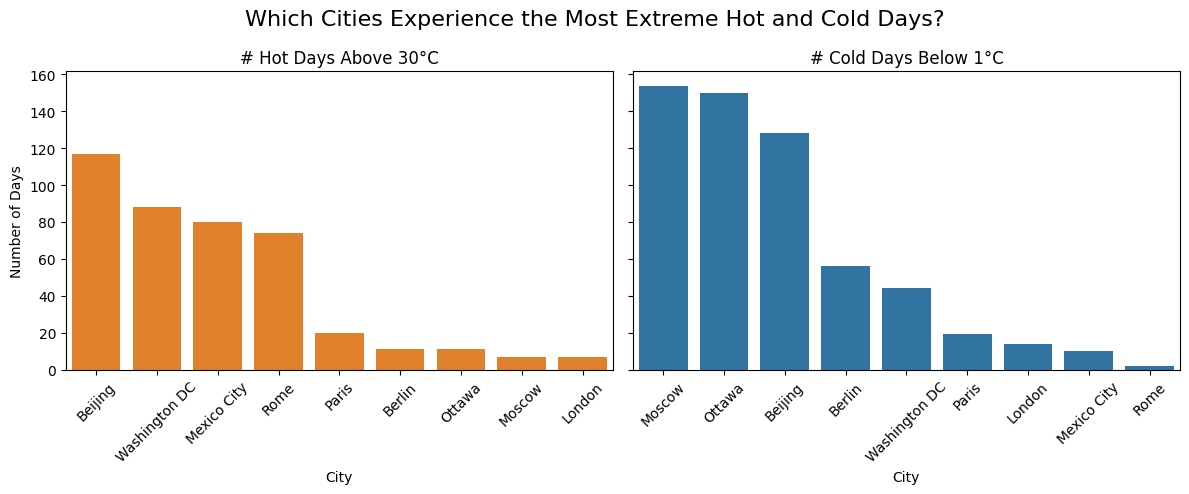

In [12]:
# List of cities to highlight in the time series plot.
highlight_cities = ['Beijing', 'Mexico City', 'Moscow']
all_cities = df.index.get_level_values('location').unique()

# Define colors for highlighted cities.
highlight_colors = {
    'Beijing': color_pal[3],
    'Mexico City': color_pal[6],
    'Moscow': color_pal[0]
}

# Set up the subplot structure for extreme hot and cold days.
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plotting hot days on the first subplot.
sns.barplot(
    x=hot_counts.index,
    y=hot_counts.values,
    color=color_pal[1],
    dodge=False,
    ax=axes[0]
)
axes[0].set_title('# Hot Days Above 30°C')
axes[0].set_xlabel('City')
axes[0].set_ylabel('Number of Days')
axes[0].tick_params(axis='x', rotation=45)

# Plotting cold days on the second subplot.
sns.barplot(
    x=cold_counts.index,
    y=cold_counts.values,
    color=color_pal[0],
    dodge=False,
    ax=axes[1]
)
axes[1].set_title('# Cold Days Below 1°C')
axes[1].set_xlabel('City')
axes[1].set_ylabel('# Days')
axes[1].tick_params(axis='x', rotation=45)

# Set the overall title for the bar subplots.
fig.suptitle('Which Cities Experience the Most Extreme Hot and Cold Days?', fontsize=16)

# Adjust layout for better spacing.
plt.tight_layout()
plt.show()


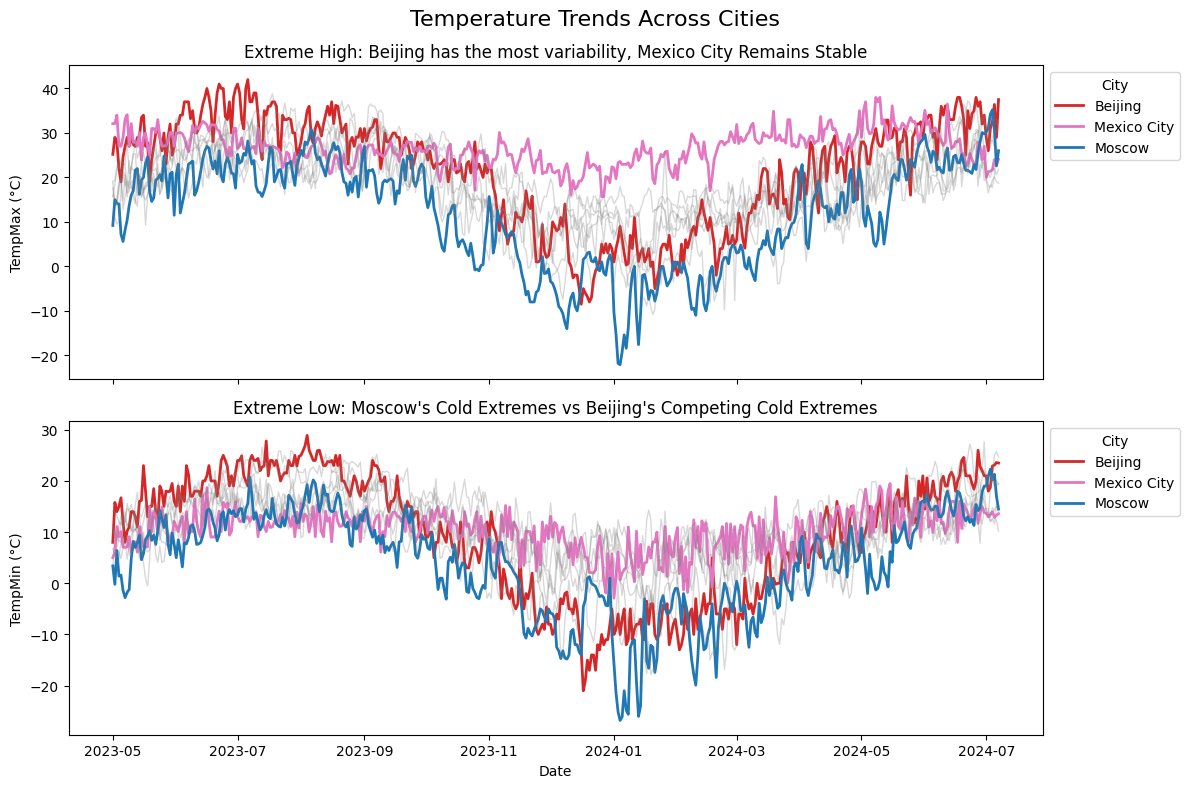

In [13]:
# Set up the subplot structure for time series plots.
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot for TempMax
for city in all_cities:
    city_data = df.xs(city, level='location').reset_index()
    if city in highlight_cities:
        sns.lineplot(
            data=city_data,
            x='datetime',
            y='tempmax',
            ax=axes[0],
            label=city,
            color=highlight_colors[city],
            linewidth=2
        )
    else:
        sns.lineplot(
            data=city_data,
            x='datetime',
            y='tempmax',
            ax=axes[0],
            color='gray',
            alpha=0.3,
            linewidth=1
        )
axes[0].set_title("Extreme High: Beijing has the most variability, Mexico City Remains Stable")
axes[0].set_ylabel('TempMax (°C)')
axes[0].legend(title='City', bbox_to_anchor=(1, 1), loc='upper left')

# Plot for TempMin
for city in all_cities:
    city_data = df.xs(city, level='location').reset_index()
    if city in highlight_cities:
        sns.lineplot(
            data=city_data,
            x='datetime',
            y='tempmin',
            ax=axes[1],
            label=city,
            color=highlight_colors[city],
            linewidth=2
        )
    else:
        sns.lineplot(
            data=city_data,
            x='datetime',
            y='tempmin',
            ax=axes[1],
            color='gray',
            alpha=0.3,
            linewidth=1
        )
axes[1].set_title("Extreme Low: Moscow's Cold Extremes vs Beijing's Competing Cold Extremes")
axes[1].set_ylabel('TempMin (°C)')
axes[1].set_xlabel('Date')
axes[1].legend(title='City', bbox_to_anchor=(1, 1), loc='upper left')

# Set the overall title for the time series plots.
fig.suptitle('Temperature Trends Across Cities', fontsize=16)

# Adjust the layout.
plt.tight_layout()
plt.show()


### Findings
- **Beijing** experiences the highest number of hot days (117) and ranks third in cold days (128), indicating a climate with significant temperature variability.
- **Washington DC** experiences a significant number of hot days ranking second (88) and ranking fifth in cold days (44) showing patterns of warm weather.
- **Mexico City** shows low variability in temperature extremes, ranking third in hot days (80) and having very few cold days (10). This pattern reflects a more temperate climate with a tendency toward warmer temperatures and fewer extremes.
- **Moscow** has the highest number of cold days (154) where temperatures drop below 1°C, highlighting its long and harsh winter season.
- **European** cities such as **Paris**, **Berlin**, and **London** have relatively fewer hot days, with **Moscow** and **London** experiencing the least (7 days each). These cities also have a moderate number of cold days, suggesting milder summer temperatures and a relatively mild winter season compared to the colder climates of **Moscow** and **Ottawa**.


Extreme events can significantly impact the accuracy of predictions. They may require special handling or additional features in our model and understanding their distribution is crucial for building robust predictive models. 


### Correlation Analysis
Next, we analyze feature correlations to understand the relationships between variables, which can help identify multicollinearity and inform feature selection.

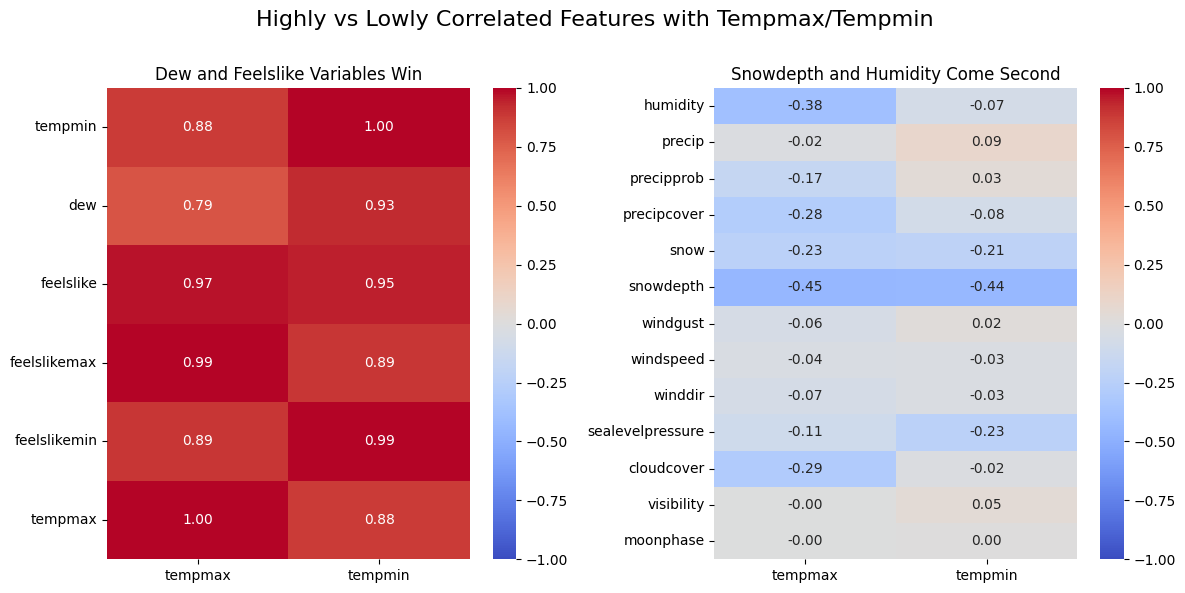

In [14]:
# Select numerical features for correlation analysis to identify potential multicollinearity.
numerical_features = [
    'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike',
    'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth',
    'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
    'visibility', 'moonphase'
]

# Compute the correlation matrix for the numerical features.
correlation_matrix = df[numerical_features].corr()

# Set the threshold for determining high and low correlations.
CORRELATION_THRESHOLD = 0.75

# Extract features with high correlations against TempMax and TempMin.
high_corr_max = correlation_matrix.loc['tempmax'][(correlation_matrix.loc['tempmax'] >= CORRELATION_THRESHOLD) | (correlation_matrix.loc['tempmax'] <= -CORRELATION_THRESHOLD)]
high_corr_min = correlation_matrix.loc['tempmin'][(correlation_matrix.loc['tempmin'] >= CORRELATION_THRESHOLD) | (correlation_matrix.loc['tempmin'] <= -CORRELATION_THRESHOLD)]

# Combine high-correlation features.
high_corr_features = list(set(high_corr_max.index.tolist() + high_corr_min.index.tolist()))

# Create a new correlation matrix for features with high correlations.
high_correlation_matrix = correlation_matrix.loc[high_corr_features, ['tempmax', 'tempmin']]

# Create a new correlation matrix for features with low correlations.
low_correlation_matrix = correlation_matrix.drop(high_corr_features).loc[:, ['tempmax', 'tempmin']]

# Create subplots for the correlation matrices.
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the heatmap for features with high correlations against TempMax and TempMin.
sns.heatmap(
    high_correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    vmin=-1,
    vmax=1,
    ax=axes[0]
)
axes[0].set_title("Dew and Feelslike Variables Win")

# Plot the heatmap for features with low correlations against TempMax and TempMin.
sns.heatmap(
    low_correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    vmin=-1,
    vmax=1,
    ax=axes[1]
)
axes[1].set_title("Snowdepth and Humidity Come Second")

# Set the main title for the figure.
fig.suptitle("Highly vs Lowly Correlated Features with Tempmax/Tempmin", fontsize=16)

# Adjust the layout for better spacing.
plt.tight_layout()

# Adjust top margin to make room for the main title.
plt.subplots_adjust(top=0.85)
plt.show()


### Statistical Summary
Analyzing the central tendency, symmetry, and variability of our dataset provides insights into its distribution and potential impacts on model performance.

In [15]:
# Display summary statistics for the dataset.
display(df.describe())


,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase
count,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000
mean,18.955402,9.414849,14.202330,18.499795,8.157168,13.398541,7.346467,67.568152,1.929340,48.888121,10.350663,0.087839,1.556759,35.276165,21.005428,191.912801,1014.354916,58.267588,16.540374,0.487063
std,9.830447,8.251788,8.749541,10.906910,9.876715,10.188162,8.307355,15.369026,5.591233,49.747341,16.836617,0.816638,7.414970,13.533089,7.653159,100.153515,8.854499,27.783827,8.760752,0.288540
min,-22.100000,-26.800000,-24.900000,-30.900000,-35.400000,-33.100000,-27.900000,10.100000,0.000000,0.000000,0.000000,0.000000,0.000000,5.400000,4.300000,0.000000,966.700000,0.000000,2.600000,0.000000
25%,12.500000,5.100000,9.200000,12.500000,3.000000,7.900000,3.225000,58.100000,0.000000,0.000000,0.000000,0.000000,0.000000,25.900000,15.900000,112.900000,1009.600000,38.000000,10.000000,0.250000
50%,20.600000,10.500000,15.800000,20.600000,10.500000,15.800000,8.800000,69.600000,0.000000,0.000000,0.000000,0.000000,0.000000,34.200000,20.100000,203.400000,1014.800000,61.850000,14.100000,0.500000
75%,26.400000,15.000000,20.200000,26.300000,15.000000,20.200000,13.000000,79.100000,1.059000,100.000000,12.500000,0.000000,0.000000,43.200000,24.900000,271.700000,1019.575000,81.900000,21.200000,0.750000
max,42.000000,28.900000,33.000000,46.000000,36.700000,40.800000,27.700000,99.500000,134.000000,100.000000,100.000000,24.800000,62.200000,175.700000,178.500000,359.900000,1044.300000,100.000000,49.600000,0.980000


### Target Distribution
Both `TempMax` and `TempMin` are left-skewed, meaning there are more higher temperatures with longer tails on the lower end. Their kurtosis values are low, indicating fewer extreme temperatures (outliers).

tempmax - Mean: 18.9554, Median: 20.6000, Skewness: -0.6370, Kurtosis: 0.1568
tempmin - Mean: 9.4148, Median: 10.5000, Skewness: -0.7782, Kurtosis: 0.8639


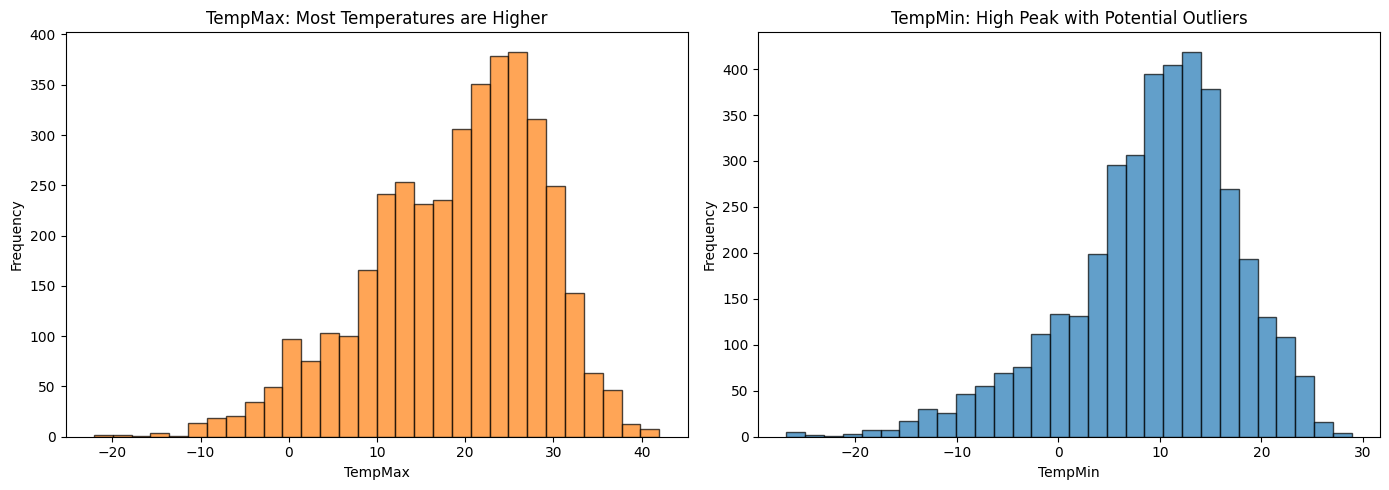

In [16]:
# Calculate statistics (mean, median, skewness, kurtosis) for TempMax and TempMin.
stats = {}
for column in ['tempmax', 'tempmin']:
    stats[column] = {
        'mean': df[column].mean(),
        'median': df[column].median(),
        'skewness': skew(df[column]),
        'kurtosis': kurtosis(df[column])
    }

    print(
        f"{column} - Mean: {stats[column]['mean']:.4f}, "
        f"Median: {stats[column]['median']:.4f}, "
        f"Skewness: {stats[column]['skewness']:.4f}, "
        f"Kurtosis: {stats[column]['kurtosis']:.4f}"
    )

# Create subplots for histograms of TempMax and TempMin.
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for TempMax.
axes[0].hist(
    df['tempmax'],
    bins=30,
    edgecolor='k',
    alpha=0.7,
    color=color_pal[1]
)
axes[0].set_title('TempMax: Most Temperatures are Higher')
axes[0].set_xlabel('TempMax')
axes[0].set_ylabel('Frequency')

# Histogram for TempMin.
axes[1].hist(
    df['tempmin'],
    bins=30,
    edgecolor='k',
    alpha=0.7,
    color=color_pal[0]
)
axes[1].set_title('TempMin: High Peak with Potential Outliers')
axes[1].set_xlabel('TempMin')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Findings:
- **No duplicate values**: Ensures data integrity and reliability for modeling.
- **Missing values are minimal**: The affected columns can be dropped without significant data loss.
- **High correlation among features**: Particularly among temperature and feels-like metrics, indicating potential multicollinearity that needs addressing. `Snowdepth` and `Humidity` show some moderate negative correlation to targets.
- **Varied distribution patterns**: Features like precipitation and snow are sporadic but significant when they occur, suggesting the need for potential transformations.
- **Dynamic features**: Variability in features like wind direction and pressure suggests they could be crucial for model accuracy.
### Actions:
- **Drop irrelevant columns** to focus on more pertinent features.
- **Address multicollinearity** by removing or combining highly correlated features.
- **Transform skewed features** like precipitation and snow to normalize their distributions.
- **Consider feature engineering** on dynamic features to enhance their predictive power.


## **Next, Feature Selection and Engineering**


### Initial Feature Assessment
**Purpose**: Identify multicollinearity among features with Variance Inflation Factor (VIF) test 

**Key Finding**: Significant multicollinearity was present, especially in temperature-related and humidity features
- e.g., VIF `feelslike` was **512.31**, and for `humidity`, it was **357.71**. (VIF > 10 indicates significant multicollinearity)

In [17]:
# Drop target variables to conduct VIF test.
all_features = df[numerical_features].drop(['tempmax', 'tempmin'], axis=1)


# Calculate VIF for each feature.
vif_data = pd.DataFrame()
vif_data["feature"] = all_features.columns
vif_data["VIF"] = [variance_inflation_factor(all_features.values, i) for i in range(all_features.shape[1])]

# Display VIF data.
display(vif_data)


,feature,VIF
0,feelslikemax,252.954949
1,feelslikemin,73.212278
2,feelslike,512.314310
3,dew,125.018260
4,humidity,357.713279
5,precip,1.578707
6,precipprob,3.837234
7,precipcover,3.380402
8,snow,1.187286
9,snowdepth,1.482063


### Feature Combination to Reduce Multicollinearity
Created new combined features, such as `feelslike_max_combined` and `dew_humidity`, to preserve the information contained in the correlated variables and represent their average.

In [18]:
# Combine highly correlated features of significant importance for multicollinearity.
df['feelslike_min_combined'] = df[['feelslikemin', 'feelslike']].mean(axis=1)

# Combine dew and humidity to create a feature that represents overall moisture conditions and address multicollinearity.
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

# Display created combined features.
combined_features = df[['feelslike_min_combined', 'dew_humidity']]
display(combined_features)


feelslike_min_combined  dew_humidity
location      datetime                                        
Beijing       2023-05-01                   13.05         31.40
              2023-05-02                   18.95         29.65
              2023-05-03                   17.55         35.90
              2023-05-04                   16.40         46.55
              2023-05-05                   17.25         35.70
...                                          ...           ...
Washington DC 2024-07-03                   21.90         38.05
              2024-07-04                   24.95         45.15
              2024-07-05                   28.75         51.20
              2024-07-06                   29.30         52.40
              2024-07-07                   27.20         48.50

[3906 rows x 2 columns]

### Assessing the Relationship Between Original and Combined Features
This visual inspection allows us to validate our transformations and ensures that our model is built on a solid foundation of well-understood data features.

#### Interpretation:
- **FeelsLikeMin Combined**: This combined feature effectively retains nearly all the information from the original `feelslikemin` variable. This transformation helps to maintain the key characteristics of `feelslikemin`, potentially enhancing predictive accuracy and reducing multicollinearity without sacrificing important data.
- **Dew_Humidity Combined**: Both `dew` and `humidity` showed significant impact on predictive performance but caused multicollinearity, while this combined feature captures a relationship between `dew` and `humidity`, it's not as strong or linear as the relationship for `feelslikemin` and `feelslike_min_combined`. A feature with a wider spread may still provide valuable insights by capturing different aspects of the data. To determine the usefulness of `dew_humidity` and `feelslike_min_combined`, it's important to test their impact on model performance.


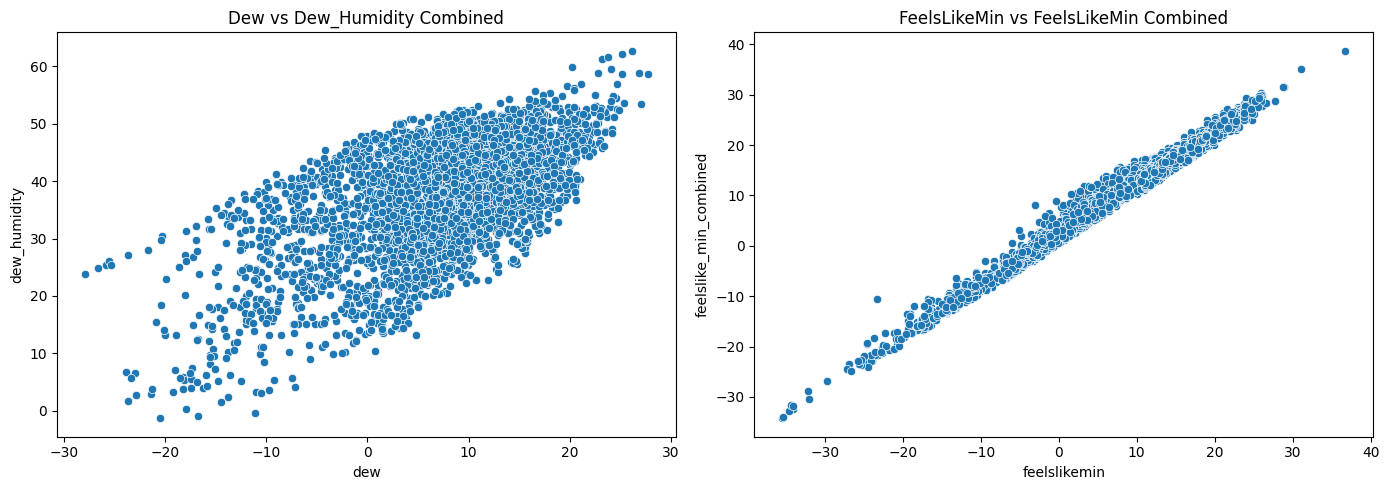

In [19]:
# Scatter plots for combined features vs original features.
plt.figure(figsize=(14, 5))

# Dew vs Dew_Humidity Combined
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['dew'], y=df['dew_humidity'])
plt.title('Dew vs Dew_Humidity Combined')

# FeelsLikeMin vs FeelsLikeMin Combined
plt.subplot(1, 2, 2)
sns.scatterplot(x=df['feelslikemin'], y=df['feelslike_min_combined'])
plt.title('FeelsLikeMin vs FeelsLikeMin Combined')

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
<b>Combined Features:</b> Significantly reduced multicollinearity and autocorrelation. Despite a slight decrease in R², the models became more reliable and interpretable, making them better suited for predicting TempMax and TempMin in time series contexts where temporal dependencies are critical.
</div>

### Addressing Autocorrelation
**Objective**: Introduce lagged variables to capture temporal dependencies and improve model performance.
- **Process**: Added lagged variables for key features based on autocorrelation analysis.
- **Implementation**: Functions were created to generate lagged variables and interpolate missing values. Key lagged features like `feelslikemax_lags` and `dew_humidity_lags` were used in the final model.

In [20]:
# Define thresholds for extreme temperatures.
MAX_TEMP_THRESHOLD = 30
MIN_TEMP_THRESHOLD = 1

# Create binary features to indicate extreme temperatures.
df['high_temp'] = (df['tempmax'] > MAX_TEMP_THRESHOLD).astype(int)
df['low_temp'] = (df['tempmin'] < MIN_TEMP_THRESHOLD).astype(int)


In [21]:
def create_lagged_variables(df, columns, lags):
    """
    Create lagged variables for given columns and lags.
    """
    for col in columns:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df


def interpolate_columns(df, columns):
    """
    Interpolate lagged variables to fill missing values.
    """
    df[columns] = df[columns].interpolate()
    return df


# Define columns and lags for creating lagged variables.
tempmax_columns = ['feelslikemax']
tempmin_columns = ['dew_humidity', 'snow']
short_lags = [1]
all_lags = [1, 4, 7, 19]

# Create lagged variables for TempMax and TempMin related features.
df = create_lagged_variables(df, tempmax_columns, short_lags)
df = create_lagged_variables(df, tempmin_columns, all_lags)

# Define lagged columns for interpolation.
lagged_columns = [f'{col}_lag{lag}' for col in tempmax_columns for lag in short_lags] + \
                 [f'{col}_lag{lag}' for col in tempmin_columns for lag in all_lags]

# Interpolate lagged variables to fill missing values.
df = interpolate_columns(df, lagged_columns)

# Drop any remaining null values in the DataFrame.
df = df.dropna()


# Combine lagged values by taking the mean to reduce multicollinearity.
df['feelslikemax_lags'] = df[['feelslikemax', 'feelslikemax_lag1']].mean(axis=1)
df['dew_humidity_lags'] = df[[f'dew_humidity_lag{lag}' for lag in all_lags]].mean(axis=1)
df['snow_lags'] = df[['snow', 'snow_lag1']].mean(axis=1)

# Recalculate the features DataFrame with lagged variables for TempMax.
features_combined_max = df[['feelslikemax_lags', 'dew_humidity', 'snow', 'windgust', 'high_temp', 'low_temp']]

# Recalculate the features DataFrame with lagged variables for TempMin.
features_combined_min = df[['feelslike_min_combined', 'dew_humidity_lags', 'snow_lags', 'precipcover', 'high_temp', 'low_temp']]

# Drop any remaining null values in the DataFrame.
df = df.dropna()

# Combine lagged values by taking the mean to reduce multicollinearity.
df['feelslikemax_lags'] = df[['feelslikemax', 'feelslikemax_lag1']].mean(axis=1)
df['dew_humidity_lags'] = df[[f'dew_humidity_lag{lag}' for lag in all_lags]].mean(axis=1)
df['snow_lags'] = df[['snow', 'snow_lag1']].mean(axis=1)

# Recalculate the features DataFrame with lagged variables for TempMax.
features_combined_max = df[['feelslikemax_lags', 'dew_humidity', 'snow', 'windgust', 'high_temp', 'low_temp']]

# Recalculate the features DataFrame with lagged variables for TempMin.
features_combined_min = df[['feelslike_min_combined', 'dew_humidity_lags', 'snow_lags', 'precipcover', 'high_temp', 'low_temp']]


<div class="alert alert-block alert-info">
<b>Data loss:</b> We encountered some data loss (approximately 4.4% of Beijing) due to missing values at the start of the time series, which could not be interpolated. These missing values were removed to maintain data integrity.
</div>

In [22]:
# Display updated row count for each location.
location_counts = df.index.get_level_values('location').value_counts()
display(location_counts)


location
Berlin           434
Ottawa           434
London           434
Mexico City      434
Moscow           434
Rome             434
Paris            434
Washington DC    434
Beijing          415
Name: count, dtype: int64

#### Conclusion:
- `hightemp` and `lowtemp`: Improve the model's performance metrics, like R² and RMSE, for predicting TempMin and reduce autocorrelation, as well as signs of heteroscedasticity for TempMax. Helping the model make more realiable and accurate predictions.
- **Lagged variables**: Reduced autocorrelation and heteroscedasticity.

### Reevaluate VIF After Feature Engineering
This is done to ensure that the engineered features reduced multicollinearity effectively.

In [23]:
# Calculate VIF for each feature in TempMax.
vif_data_max = pd.DataFrame()
vif_data_max["tempmax_feature"] = features_combined_max.columns
vif_data_max["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Calculate VIF for each feature in TempMin.
vif_data_min = pd.DataFrame()
vif_data_min["tempmin_feature"] = features_combined_min.columns
vif_data_min["VIF"] = [variance_inflation_factor(features_combined_min.values, i) for i in range(features_combined_min.shape[1])]

# Display VIF data for TempMax and TempMin.
display(vif_data_max)
display(vif_data_min)


,tempmax_feature,VIF
0,feelslikemax_lags,7.055933
1,dew_humidity,8.365145
2,snow,1.106269
3,windgust,6.026991
4,high_temp,1.517787
5,low_temp,1.701816


,tempmin_feature,VIF
0,feelslike_min_combined,6.088716
1,dew_humidity_lags,6.387382
2,snow_lags,1.217308
3,precipcover,1.593978
4,high_temp,1.509520
5,low_temp,2.458608


### Summary of Actions Taken
- **High Multicollinearity**: Identified and addressed by combining correlated features.
- **Feature Combination**: Reduced multicollinearity with new features like `feelslike_max_combined` and `dew_humidity`.
- **Lagged Variables**: Introduced to capture temporal patterns and address autocorrelation.
- **VIF Reassessment**: Confirmed reduced multicollinearity in the new feature set.

<div class="alert alert-block alert-success">
<b>Successfully:</b> Reduced VIF scores significantly, from 531.90 to a max of 8.36, improving model stability.
</div>

### Visual Analysis
- **Correlation Heatmaps**: Displayed for TempMax and TempMin features, highlighting relationships and effectiveness of feature engineering.
- **VIF Bar Plots**: Visual representation of VIF scores for TempMax and TempMin features after feature engineering.

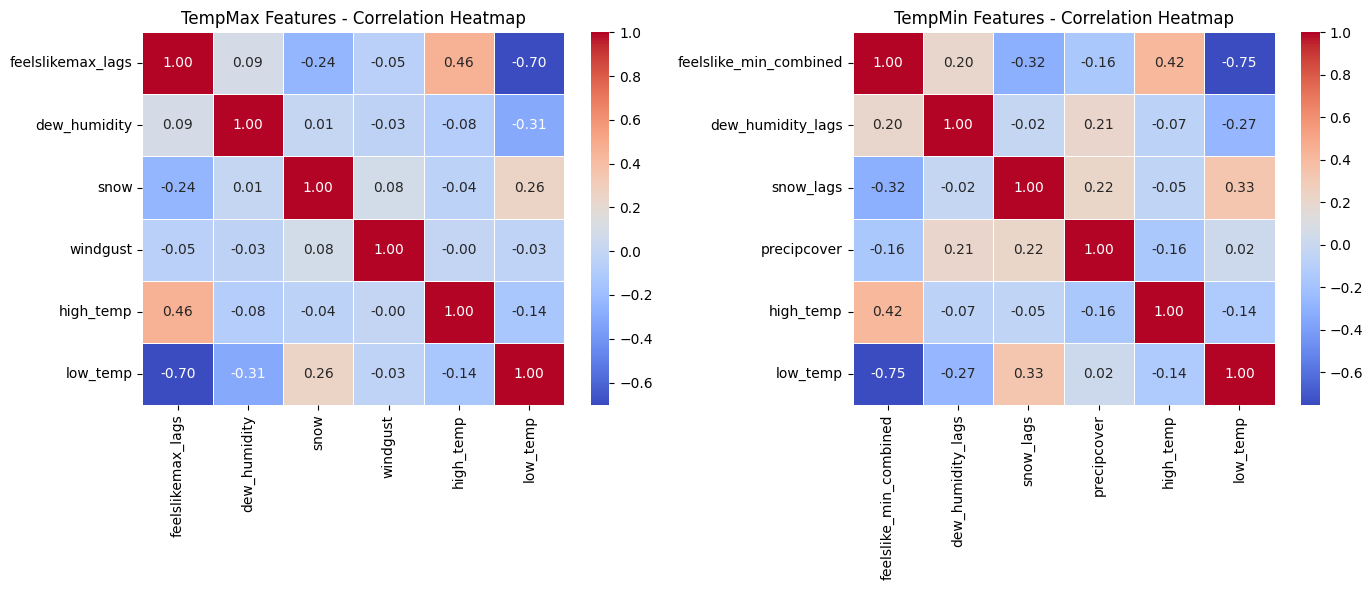

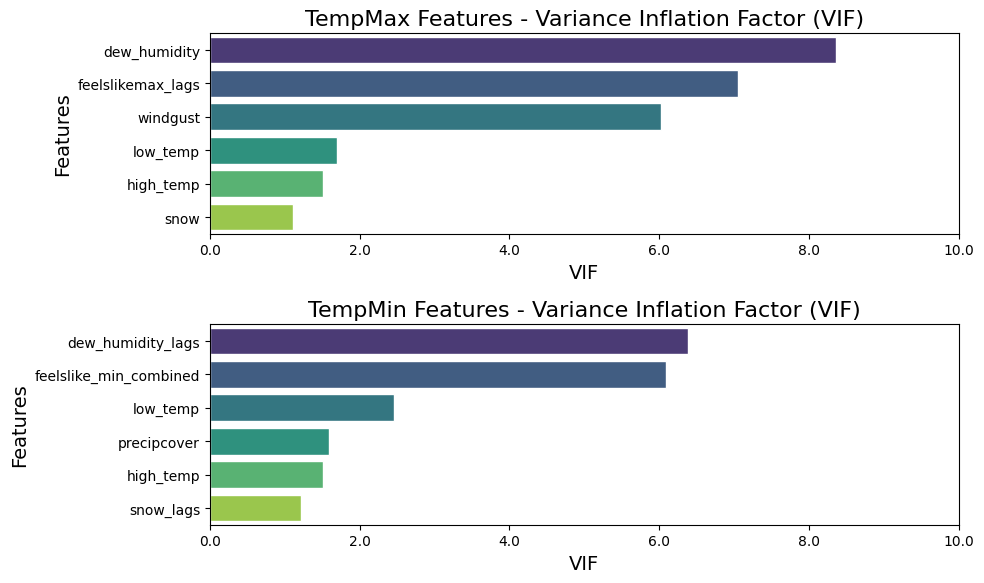

In [24]:
# Calculate the correlation matrix for TempMax and TempMin features.
correlation_matrix_max = features_combined_max.corr()
correlation_matrix_min = features_combined_min.corr()


# Create subplots for correlation heatmaps.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot heatmap for TempMax features.
sns.heatmap(correlation_matrix_max, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('TempMax Features - Correlation Heatmap')

# Plot heatmap for TempMin features.
sns.heatmap(correlation_matrix_min, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('TempMin Features - Correlation Heatmap')

# Adjust layout to prevent overlap and display heatmaps.
plt.tight_layout()
plt.show()


# Plot the Variance Inflation Factor (VIF) results for TempMax and TempMin as subplots.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
sns.set(style="whitegrid")

# Plot VIF for TempMax features.
sns.barplot(
    x="VIF",
    y="tempmax_feature",
    hue="tempmax_feature",
    dodge=False,
    data=vif_data_max.sort_values(by="VIF", ascending=False),
    palette="viridis",
    ax=axes[0],
    legend=False
)
axes[0].set_title('TempMax Features - Variance Inflation Factor (VIF)', fontsize=16)
axes[0].set_xlabel('VIF', fontsize=14)
axes[0].set_ylabel('Features', fontsize=14)
axes[0].set_xlim(0, 10)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Plot VIF for TempMin features.
sns.barplot(
    x="VIF",
    y="tempmin_feature",
    hue="tempmin_feature",
    dodge=False,
    data=vif_data_min.sort_values(by="VIF", ascending=False),
    palette="viridis",
    ax=axes[1],
    legend=False
)
axes[1].set_title('TempMin Features - Variance Inflation Factor (VIF)', fontsize=16)
axes[1].set_xlabel('VIF', fontsize=14)
axes[1].set_ylabel('Features', fontsize=14)
axes[1].set_xlim(0, 10)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Adjust layout to prevent overlap and display VIF plots.
plt.tight_layout()
plt.show()


## **Data Splitting** - Train/Validate/Test
Effective data splitting is crucial in time series analysis to maintain temporal sequence, prevent data leakage, and ensure unbiased model evaluation. The approach used ensures the model generalizes well and reflects real-world performance.

For this project, we’ve divided the data as follows:
- **Training Set (~70%)**: Used to fit the model, where it learns patterns, relationships, and trends to form the foundation of its predictions.
- **Validation Set (~10%)**: Used to fine-tune the model, aiding in model selection, feature selection, and hyperparameter tuning.
- **Test Set (~20%)**: Provides an unbiased assessment of the model’s performance on unseen data.

In [25]:
# Define split dates for training, validation, and testing sets.
TRAIN_END_DATE = pd.to_datetime('2024-03-01')
VALIDATE_END_DATE = pd.to_datetime('2024-04-13')
TEST_START_DATE = pd.to_datetime('2024-04-13')


In [26]:
# Split the data into training, validation, and testing sets based on defined dates.
train = df.loc[df.index.get_level_values('datetime') < TRAIN_END_DATE]
validate = df.loc[(df.index.get_level_values('datetime') >= TRAIN_END_DATE) & (df.index.get_level_values('datetime') < VALIDATE_END_DATE)]
test = df.loc[df.index.get_level_values('datetime') >= TEST_START_DATE]


### Visualize the Splits
Plotting temperatures with dashed lines at the split dates for visual representation.

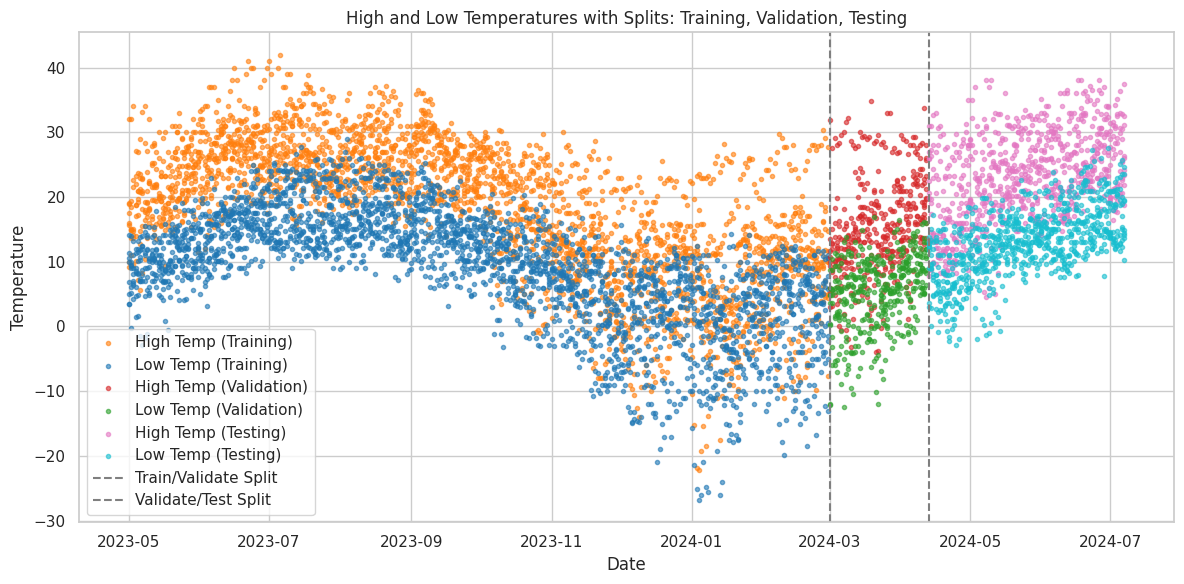

In [27]:
# Create scatter plots to visualize the splits for training, validation, and testing sets.
fig, ax = plt.subplots(figsize=(12, 6))

# Plot temperatures for each dataset: train, validate, test.
for dataset, color, label_max, label_min in zip(
    [train, validate, test],
    [(color_pal[1], color_pal[0]), (color_pal[3], color_pal[2]), (color_pal[6], color_pal[9])],
    ['High Temp (Training)', 'High Temp (Validation)', 'High Temp (Testing)'],
    ['Low Temp (Training)', 'Low Temp (Validation)', 'Low Temp (Testing)']):

    plt.scatter(
        dataset.index.get_level_values('datetime'),
        dataset['tempmax'],
        color=color[0],
        label=label_max,
        alpha=0.6,
        marker='.'
    )

    plt.scatter(
        dataset.index.get_level_values('datetime'),
        dataset['tempmin'],
        color=color[1],
        label=label_min,
        alpha=0.6,
        marker='.'
    )

# Add vertical lines to mark the splits between training, validation, and testing sets.
ax.axvline(TRAIN_END_DATE, color=color_pal[7], ls='--', label='Train/Validate Split')
ax.axvline(VALIDATE_END_DATE, color=color_pal[7], ls='--', label='Validate/Test Split')

# Add titles, labels, and legend to the plot.
plt.title('High and Low Temperatures with Splits: Training, Validation, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

# Adjust layout to prevent overlap and show the plot.
plt.tight_layout()
plt.show()


### Define Target Variables and Feature Sets
Features are our predictors and targets are what we're predicting. Defining them ensures that models are built with a clear purpose, using relevant data, which ultimately leads to better, more reliable, and interpretable models.

In [28]:
# Define target variables for maximum and minimum temperatures.
y_max = df['tempmax']
y_min = df['tempmin']

# Initialize lists to store feature names for max and min temperature models.
X_max = features_combined_max.columns.tolist()
X_min = features_combined_min.columns.tolist()

# Extract target variables for each dataset: training, validation, testing.
y_train_max, y_train_min = train['tempmax'], train['tempmin']
y_val_max, y_val_min = validate['tempmax'], validate['tempmin']
y_test_max, y_test_min = test['tempmax'], test['tempmin']

# Extract feature sets for each dataset: training, validation, testing.
X_train_max, X_val_max, X_test_max = train[X_max], validate[X_max], test[X_max]
X_train_min, X_val_min, X_test_min = train[X_min], validate[X_min], test[X_min]


### Key Takeaways: Data Splitting
- **Training Set (~70%)**: Forms the foundation for model learning by identifying patterns and trends.
- **Validation Set (~10%)**: Used to fine-tune the model, guiding decisions on model architecture, feature selection, and hyperparameter tuning.
- **Test Set (~20%)**: Provides an unbiased evaluation of the model's performance on unseen data.

## **Model Training and Evaluation**
Model training and evaluation are critical phases in developing robust and reliable machine learning models. In this project, we focus on weather forecasting using Ridge Regression to predict maximum and minimum temperatures.

### Why Ridge Regression?
Ridge Regression strikes a balance between performance and complexity. Like Linear Regression, it is simpler and more interpretable compared to complex models.

Its strengths lie in regularization, which helps manage multicollinearity and prevent overfitting, ensuring stable and reliable predictions. With consistent performance and computational efficiency, Ridge Regression provides a practical solution for predicting weather while maintaining simplicity and reliability.

![regularization gif](https://miro.medium.com/v2/resize:fit:1000/1*n-fid04EiwcTZZPO0RXlMQ.gif)

[GIF Source](https://pub.towardsai.net/ridge-and-lasso-regression-51705b608fb9)

### Feature Scaling
We use **RobustScaler** to scale the feature variables, minimizing the impact of outliers and ensuring more stable Ridge Regression models.

In [29]:
# Initialize the RobustScaler for both TempMax and TempMin feature sets.
scaler_max, scaler_min = RobustScaler(), RobustScaler()

# Scale the training, validation, and test sets for TempMax.
X_train_max_scaled = scaler_max.fit_transform(X_train_max)
X_val_max_scaled = scaler_max.transform(X_val_max)
X_test_max_scaled = scaler_max.transform(X_test_max)

# Scale the training, validation, and test sets for TempMin.
X_train_min_scaled = scaler_min.fit_transform(X_train_min)
X_val_min_scaled = scaler_min.transform(X_val_min)
X_test_min_scaled = scaler_min.transform(X_test_min)


### Hyperparameter Tuning for Ridge Regression
To optimize model performance, we tuned the regularization strength (alpha) using **GridSearchCV** with five-fold cross-validation, which balances model bias and variance effectively.

In [30]:
# Define the parameter grid for alpha (regularization strength).
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Initialize Ridge Regression models for TempMax and TempMin.
ridge_max, ridge_min = Ridge(), Ridge()

# Perform GridSearchCV to find the best alpha for TempMax.
grid_search_max = GridSearchCV(ridge_max, param_grid, cv=5, scoring='r2')
grid_search_max.fit(X_train_max_scaled, y_train_max)
best_alpha_max = grid_search_max.best_params_['alpha']

# Perform GridSearchCV to find the best alpha for TempMin.
grid_search_min = GridSearchCV(ridge_min, param_grid, cv=5, scoring='r2')
grid_search_min.fit(X_train_min_scaled, y_train_min)
best_alpha_min = grid_search_min.best_params_['alpha']


### Model Training
With the best alpha values, we trained Ridge Regression models for both TempMax and TempMin, ensuring efficient regularization and better generalization.

In [31]:
# Initialize Ridge Regression models with the best alpha values found from GridSearchCV.
ridge_model_max = Ridge(alpha=best_alpha_max)
ridge_model_min = Ridge(alpha=best_alpha_min)

# Fit the models to the training data.
ridge_model_max.fit(X_train_max_scaled, y_train_max)
ridge_model_min.fit(X_train_min_scaled, y_train_min)

print(f"Best alpha tempmax: {best_alpha_max}")
print(f"Best alpha tempmin: {best_alpha_min}")


Best alpha tempmax: 10
Best alpha tempmin: 0.01


###  Feature Importance
Feature importance analysis reveals the most influential predictors in the model, guiding feature selection and potential model improvements.

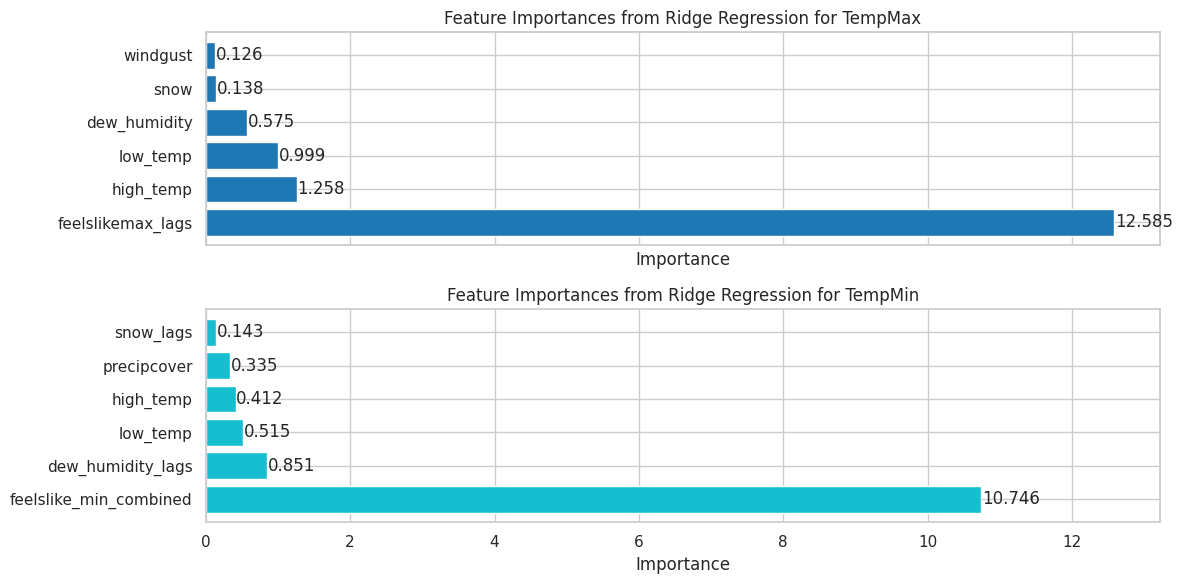

In [32]:
# Extract and sort feature importances for TempMax.
importances_max = abs(ridge_model_max.coef_)
importance_df_max = pd.DataFrame({
    'Feature': X_train_max.columns,
    'Importance': importances_max
}).sort_values(by='Importance', ascending=False)

# Extract and sort feature importances for TempMin.
importances_min = abs(ridge_model_min.coef_)
importance_df_min = pd.DataFrame({
    'Feature': X_train_min.columns,
    'Importance': importances_min
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances for TempMax and TempMin.
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

# Plot for TempMax.
ax1.barh(importance_df_max['Feature'], importance_df_max['Importance'], color=color_pal[0])
ax1.set_title('Feature Importances from Ridge Regression for TempMax')
ax1.set_xlabel('Importance')
for index, value in enumerate(importance_df_max['Importance']):
    ax1.text(value + 0.01, index, f'{value:.3f}', va='center')

# Plot for TempMin.
ax2.barh(importance_df_min['Feature'], importance_df_min['Importance'], color=color_pal[9])
ax2.set_title('Feature Importances from Ridge Regression for TempMin')
ax2.set_xlabel('Importance')
for index, value in enumerate(importance_df_min['Importance']):
    ax2.text(value + 0.01, index, f'{value:.3f}', va='center')

# Adjust layout and display the plot.
plt.tight_layout()
plt.show()


### Cross-Validation and Validation Set Evaluation
Five-fold cross-validation provides a robust estimate of model performance, while validation set evaluation with metrics such as **R²**, **RMSE**, and **Durbin-Watson** statistics checks the model fit and residual independence.

In [33]:
# Perform 5-fold cross-validation for TempMax.
cv_scores_max = cross_val_score(ridge_model_max, X_train_max_scaled, y_train_max, cv=5, scoring='r2')

# Perform 5-fold cross-validation for TempMin.
cv_scores_min = cross_val_score(ridge_model_min, X_train_min_scaled, y_train_min, cv=5, scoring='r2')

# Display cross-validation results.
print("\n--- Cross-Validation Results ---")
print(f"TempMax - Mean R²: {cv_scores_max.mean():.4f}, Scores: {cv_scores_max}")
print(f"TempMin - Mean R²: {cv_scores_min.mean():.4f}, Scores: {cv_scores_min}")



--- Cross-Validation Results ---
TempMax - Mean R²: 0.9645, Scores: [0.96474891 0.96262497 0.97086032 0.96803022 0.95644225]
TempMin - Mean R²: 0.9640, Scores: [0.98013216 0.91840004 0.96266376 0.98286278 0.975705  ]


### Key Takeaways:
**Consistency**:
- The `TempMax` model shows more consistent performance across the folds, indicating robustness to variations in the dataset. 
- The `TempMin` model has more variability in R² scores, suggesting a need for further investigation into why certain folds perform differently. 

Checking for outliers, examining data distributions, or applying additional feature engineering could help improve the model's stability and performance.

<div class="alert alert-block alert-success">
<b>High Overall Performance:</b> Both models demonstrate strong predictive capabilities with high mean R² values, indicating that the models are effective at capturing the underlying patterns in the data.
</div>

In [34]:
# Predict on the validation set for TempMax and TempMin.
y_pred_val_max = ridge_model_max.predict(X_val_max_scaled)
y_pred_val_min = ridge_model_min.predict(X_val_min_scaled)

# Calculate performance metrics and residuals for TempMax.
r2_val_max = r2_score(y_val_max, y_pred_val_max)
rmse_max = np.sqrt(mean_squared_error(y_val_max, y_pred_val_max))
residuals_max = y_val_max - y_pred_val_max
dw_stat_max = durbin_watson(residuals_max)

# Calculate performance metrics and residuals for TempMin.
r2_val_min = r2_score(y_val_min, y_pred_val_min)
rmse_min = np.sqrt(mean_squared_error(y_val_min, y_pred_val_min))
residuals_min = y_val_min - y_pred_val_min
dw_stat_min = durbin_watson(residuals_min)

# Display validation results.
print("\n--- Validation Set Results ---")
print(f"TempMax - R²: {r2_val_max:.4f}, RMSE: {rmse_max:.4f}, Durbin-Watson: {dw_stat_max:.4f}")
print(f"TempMin - R²: {r2_val_min:.4f}, RMSE: {rmse_min:.4f}, Durbin-Watson: {dw_stat_min:.4f}")



--- Validation Set Results ---
TempMax - R²: 0.9362, RMSE: 1.8857, Durbin-Watson: 1.8055
TempMin - R²: 0.9326, RMSE: 1.4565, Durbin-Watson: 1.3515


#### Validation Set Interpretation
- Both models for predicting `TempMax` and `TempMin` perform well, with high R² values and low RMSE values indicating strong predictive accuracy.
- The Durbin-Watson statistic for `TempMin` suggests some positive autocorrelation in the residuals, indicating that the model may not fully capture all data patterns and might benefit from additional features or a different modeling approach to address temporal dependencies.

#### Autocorrelation and Heteroscedasticity Checks
We used **ACF** and **PACF** plots to examine residual autocorrelation and **Breusch-Pagan** tests to detect heteroscedasticity, ensuring that model assumptions hold and the predictions are reliable.


--- Breusch-Pagan Test Results ---
TempMax:
LM Statistic: 10.7307
LM Test p-value: 0.0971
F-Statistic: 1.8062
F-Test p-value: 0.0967
TempMin:
LM Statistic: 84.1248
LM Test p-value: 0.0000
F-Statistic: 17.5911
F-Test p-value: 0.0000


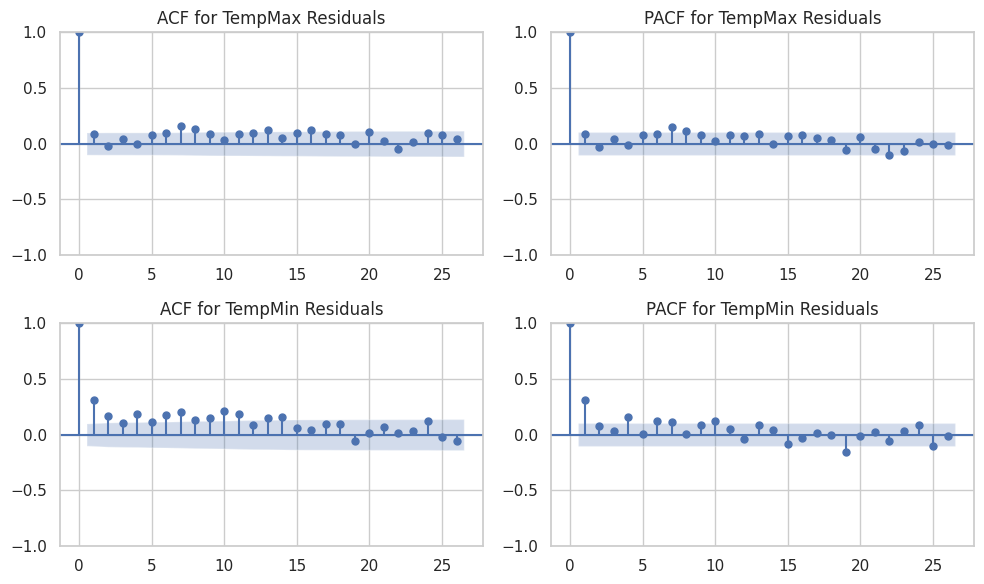

In [35]:
# Add a constant to the validation set features.
X_val_max_scaled_with_const = sm.add_constant(X_val_max_scaled)
X_val_min_scaled_with_const = sm.add_constant(X_val_min_scaled)

# Perform the Breusch-Pagan test on the residuals for TempMax and TempMin.
bp_test_max = het_breuschpagan(residuals_max, X_val_max_scaled_with_const)
bp_test_min = het_breuschpagan(residuals_min, X_val_min_scaled_with_const)

# Display Breusch-Pagan test results.
labels = ['LM Statistic', 'LM Test p-value', 'F-Statistic', 'F-Test p-value']
print("\n--- Breusch-Pagan Test Results ---")
print('TempMax:')
for label, result in zip(labels, bp_test_max):
    print(f'{label}: {result:.4f}')
print('TempMin:')
for label, result in zip(labels, bp_test_min):
    print(f'{label}: {result:.4f}')

# Calculate fitted values for the validation set.
fitted_values_max = ridge_model_max.predict(X_val_max_scaled)
fitted_values_min = ridge_model_min.predict(X_val_min_scaled)

# Plot ACF and PACF of residuals for TempMax and TempMin.
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# ACF for TempMax Residuals.
plot_acf(residuals_max, ax=ax[0, 0])
ax[0, 0].set_title('ACF for TempMax Residuals')

# ACF for TempMin Residuals.
plot_acf(residuals_min, ax=ax[1, 0])
ax[1, 0].set_title('ACF for TempMin Residuals')

# PACF for TempMax Residuals.
plot_pacf(residuals_max, ax=ax[0, 1])
ax[0, 1].set_title('PACF for TempMax Residuals')

# PACF for TempMin Residuals.
plot_pacf(residuals_min, ax=ax[1, 1])
ax[1, 1].set_title('PACF for TempMin Residuals')

# Adjust layout and display the plots.
plt.tight_layout()
plt.show()


#### Conclusions
**Autocorrelation**:
- **TempMax Model**: The model performs well with minimal autocorrelation.
- **TempMin Model**: The model shows moderate positive autocorrelation, especially at lag 1, with a Durbin-Watson statistic of 1.3515. This suggests that further adjustments may be needed to better capture temporal patterns.

**Breusch-Pagan Test**:
- **TempMax**: The model is reliable, with no significant issues with heteroskedasticity or autocorrelation. It performs consistently with high R² and low RMSE values, making it robust for predicting maximum temperature.
- **TempMin**: While the model performs well overall with high R² values, it shows significant heteroskedasticity and some autocorrelation. This could impact reliability under certain conditions, and further refinement may be needed.

**Overall**: Both models are acceptable for real-world use, but improving the TempMin model's handling of heteroskedasticity would enhance its robustness.

### Performance Metrics
To complement RMSE, we also calculated **Mean Absolute Error (MAE)** and **Adjusted R²** to provide a comprehensive view of the model's predictive accuracy and goodness-of-fit.

In [36]:
# Calculate Mean Absolute Error (MAE) for TempMax and TempMin.
mae_max = mean_absolute_error(y_val_max, y_pred_val_max)
mae_min = mean_absolute_error(y_val_min, y_pred_val_min)
print(f"TempMax - MAE: {mae_max:.4f}")
print(f"TempMin - MAE: {mae_min:.4f}")

# Calculate Adjusted R² for TempMax and TempMin.
n_max, p_max = X_val_max_scaled.shape
n_min, p_min = X_val_min_scaled.shape
adjusted_r2_max = 1 - (1 - r2_val_max) * (n_max - 1) / (n_max - p_max - 1)
adjusted_r2_min = 1 - (1 - r2_val_min) * (n_min - 1) / (n_min - p_min - 1)
print(f"TempMax - Adjusted R²: {adjusted_r2_max:.4f}")
print(f"TempMin - Adjusted R²: {adjusted_r2_min:.4f}")


TempMax - MAE: 1.4335
TempMin - MAE: 1.1215
TempMax - Adjusted R²: 0.9352
TempMin - Adjusted R²: 0.9315


#### Interpretation
**Mean Absolute Error (MAE)**:
- **TempMax: 1.4335** – On average, the model's predictions for `TempMax` are 1.43 units away from the actual values, indicating good predictive accuracy.
- **TempMin: 1.1215** – The predictions for `TempMin` are off by about 1.12 units on average, showing that the model is also accurate for minimum temperatures.

**Adjusted R²**:
- **TempMax: 0.9352** – This means the model explains 93.52% of the variability in `TempMax`, accounting for the number of predictors. It indicates strong model performance.
- **TempMin: 0.9315** – The model explains 93.15% of the variability in `TempMin`, also reflecting strong predictive power.

These metrics show that both models predict maximum and minimum temperatures accurately and effectively.

### Visualizing the Results
To better understand the model’s predictions, we visualize the actual vs. predicted values, residuals, and their distribution.
- **Actual vs. Predicted Values**: This plot shows how closely the predicted values align with the actual values over time. Ideally, the predicted line would follow the actual line closely if not perfectly, indicating that the model is accurately capturing the temperature trends.
- **Residuals Distribution**: Ideally, the residuals should follow a normal distribution, as shown in the top row of the reference image. A normal residual distribution suggests that the model errors are random and unbiased.

![image.png](https://miro.medium.com/v2/0*lsbu809F5gOZrrKX)

[Image Source](https://medium.com/aiskunks/crash-course-in-data-seeing-is-believing-exploring-data-distributions-with-q-q-plots-803992fae0da)


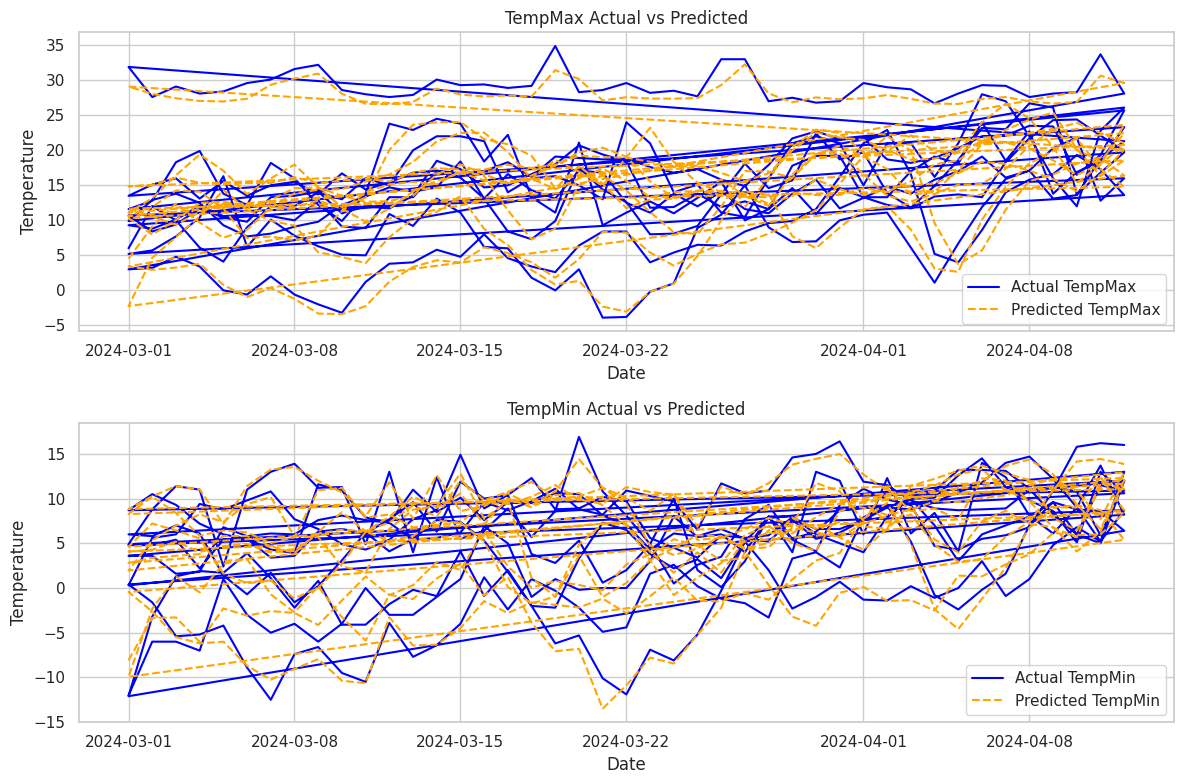

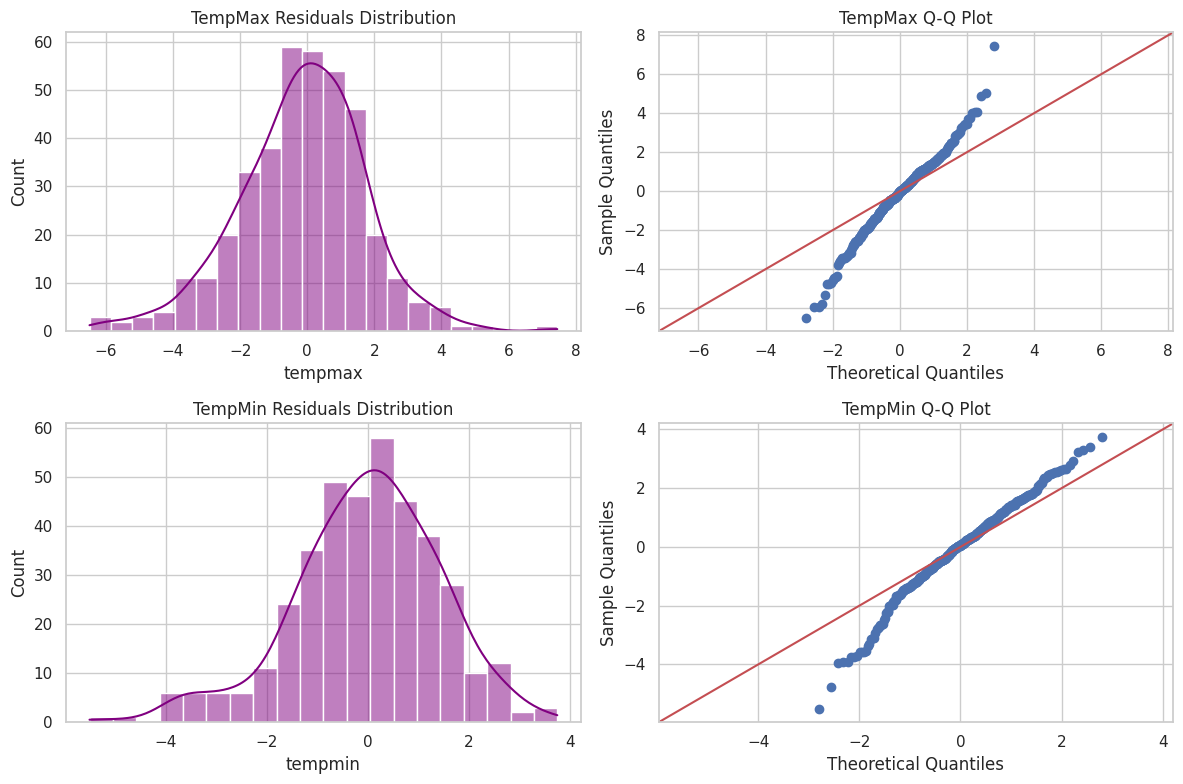

In [37]:
# Plot Actual vs Predicted values for TempMax and TempMin
plt.figure(figsize=(12, 8))

# TempMax plot
plt.subplot(2, 1, 1)
plt.plot(y_val_max.index.get_level_values('datetime'), y_val_max, label='Actual TempMax', color='blue')
plt.plot(y_val_max.index.get_level_values('datetime'), y_pred_val_max, label='Predicted TempMax', color='orange', linestyle='--')
plt.title('TempMax Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

# TempMin plot
plt.subplot(2, 1, 2)
plt.plot(y_val_min.index.get_level_values('datetime'), y_val_min, label='Actual TempMin', color='blue')
plt.plot(y_val_min.index.get_level_values('datetime'), y_pred_val_min, label='Predicted TempMin', color='orange', linestyle='--')
plt.title('TempMin Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Residuals distribution and Q-Q plots.
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# TempMax Residuals distribution.
sns.histplot(residuals_max, kde=True, ax=ax[0, 0], color='purple')
ax[0, 0].set_title('TempMax Residuals Distribution')
sm.qqplot(residuals_max, line ='45', ax=ax[0, 1])
ax[0, 1].set_title('TempMax Q-Q Plot')

# TempMin Residuals distribution.
sns.histplot(residuals_min, kde=True, ax=ax[1, 0], color='purple')
ax[1, 0].set_title('TempMin Residuals Distribution')
sm.qqplot(residuals_min, line ='45', ax=ax[1, 1])
ax[1, 1].set_title('TempMin Q-Q Plot')

plt.tight_layout()
plt.show()


#### Conclusion
- The residuals for both `TempMax` and `TempMin` are not normally distributed, but this level of non-normality is acceptable for Ridge Regression. Since Ridge focuses on prediction and controlling multicollinearity rather than strict normality, the model can still make accurate predictions.
- The actual vs predicted plot shows good accuracy with acceptable deviation from actual values.

## **Model Evaluation Summary**
### Predicting on the Test Set
Predicting on the test set validates the model's ability to generalize, ensuring robustness and avoiding overfitting. This final step confirms the model's readiness for practical use.

In [38]:
# Predict TempMax and TempMin using the trained Ridge Regression models
y_pred_test_max = ridge_model_max.predict(X_test_max_scaled)
y_pred_test_min = ridge_model_min.predict(X_test_min_scaled)


### Residual Analysis

In [39]:
# Calculate residuals for TempMax and TempMin
residuals_test_max = y_test_max - y_pred_test_max
residuals_test_min = y_test_min - y_pred_test_min

# Compute Durbin-Watson statistic to check for autocorrelation in residuals
dw_stat_test_max = durbin_watson(residuals_test_max)
dw_stat_test_min = durbin_watson(residuals_test_min)

# Display Durbin-Watson statistics
print(f"TempMax - Durbin-Watson: {dw_stat_test_max:.4f}")
print(f"TempMin - Durbin-Watson: {dw_stat_test_min:.4f}")

# Add a constant to the test set features.
X_test_max_scaled_with_const = sm.add_constant(X_test_max_scaled)
X_test_min_scaled_with_const = sm.add_constant(X_test_min_scaled)

# Perform the Breusch-Pagan test on the residuals for TempMax and TempMin.
bp_test_max = het_breuschpagan(residuals_test_max, X_test_max_scaled_with_const)
bp_test_min = het_breuschpagan(residuals_test_min, X_test_min_scaled_with_const)

# Display Breusch-Pagan test results.
labels = ['LM Statistic', 'LM Test p-value', 'F-Statistic', 'F-Test p-value']
print("\n--- Breusch-Pagan Test Results ---")
print('TempMax:')
for label, result in zip(labels, bp_test_max):
    print(f'{label}: {result:.4f}')
print('TempMin:')
for label, result in zip(labels, bp_test_min):
    print(f'{label}: {result:.4f}')

TempMax - Durbin-Watson: 1.7461
TempMin - Durbin-Watson: 1.4067

--- Breusch-Pagan Test Results ---
TempMax:
LM Statistic: 4.5026
LM Test p-value: 0.6090
F-Statistic: 0.7480
F-Test p-value: 0.6111
TempMin:
LM Statistic: 89.5283
LM Test p-value: 0.0000
F-Statistic: 16.7205
F-Test p-value: 0.0000


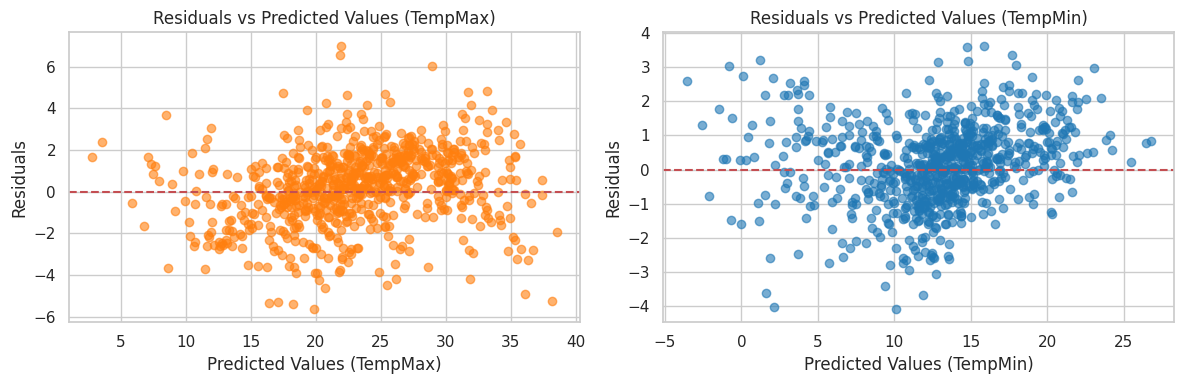

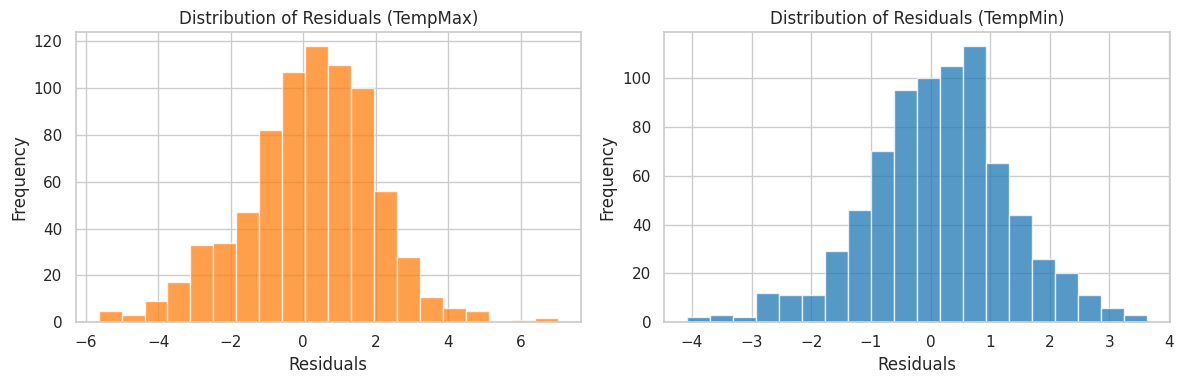

In [40]:
# Plot residuals vs fitted values for TempMax and TempMin
plt.figure(figsize=(12, 4))

# Plot for TempMax
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test_max, residuals_test_max, color=color_pal[1], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (TempMax)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (TempMax)')
plt.grid(True)

# Plot for TempMin
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test_min, residuals_test_min, color=color_pal[0], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (TempMin)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (TempMin)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the distribution of residuals (histogram)
plt.figure(figsize=(12, 4))

# Histogram for TempMax Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_test_max, bins=20, color=color_pal[1], alpha=0.75)
plt.title('Distribution of Residuals (TempMax)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for TempMin Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_test_min, bins=20, color=color_pal[0], alpha=0.75)
plt.title('Distribution of Residuals (TempMin)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


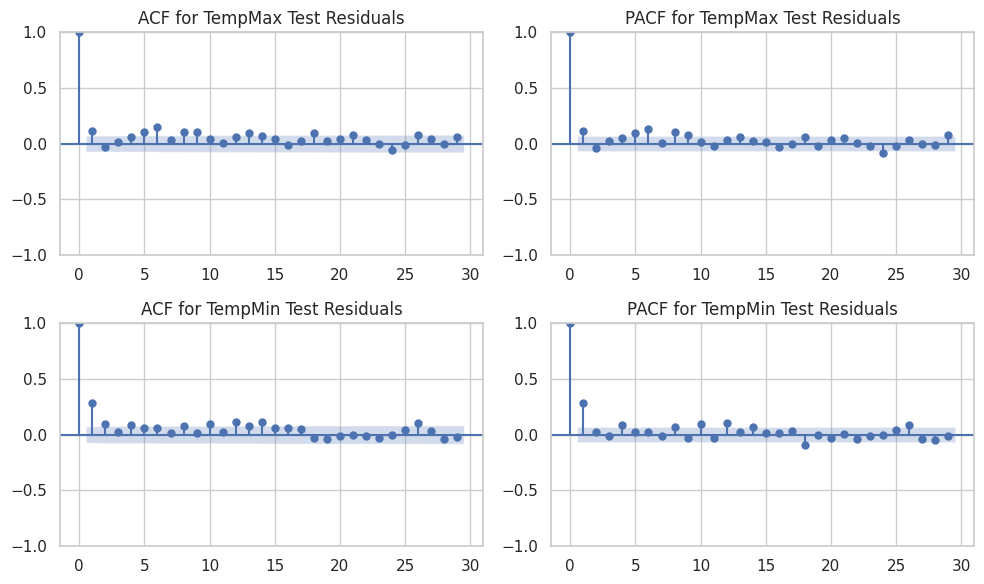

In [41]:
# Plot ACF and PACF of residuals for TempMax and TempMin
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# ACF for TempMax Residuals
plot_acf(residuals_test_max, ax=ax[0, 0])
ax[0, 0].set_title('ACF for TempMax Test Residuals')

# ACF for TempMin Residuals
plot_acf(residuals_test_min, ax=ax[1, 0])
ax[1, 0].set_title('ACF for TempMin Test Residuals')

# PACF for TempMax Residuals
plot_pacf(residuals_test_max, ax=ax[0, 1])
ax[0, 1].set_title('PACF for TempMax Test Residuals')

# PACF for TempMin Residuals
plot_pacf(residuals_test_min, ax=ax[1, 1])
ax[1, 1].set_title('PACF for TempMin Test Residuals')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


**In summary, the results imply that**:
- The performance of the model regarding autocorrelation showed marginal change for `TempMax` in the test set compared to the validation set while showing persistence in positive autocorrelation for `TempMin`, albeit with a slight improvement.
- The model's consistency regarding the variance of residuals (homoscedasticity) improved for `TempMax`, while `TempMin` exhibited a slight increase in heteroskedasticity in the test set compared to validation, suggesting potential increases in errors associated with the prediction of `TempMin`.

Overall, while the model appears to have stabilized for `TempMax`, it shows varying robustness for `TempMin` indicating a need for further tuning or alternative modeling approaches for improving predictions on this variable.

### Generating and Storing Predictions
The following code snippet is used to generate and store the predictions of our Ridge Regression models on the test dataset.

This approach consolidates the actual test data and model predictions into a single dataframe, making it easier to compare predicted values with actual values.

In [42]:
# Create a DataFrame to store predictions and actual values
predicted_df = test.copy()
predicted_df['predicted_max'] = y_pred_test_max
predicted_df['predicted_min'] = y_pred_test_min
predicted_df = predicted_df[['tempmax', 'predicted_max', 'tempmin', 'predicted_min']].copy()


In [43]:
# Display the first few rows of the DataFrame
display(predicted_df.head())


tempmax  predicted_max  tempmin  predicted_min
location datetime                                                  
Beijing  2024-04-13     27.0      25.700171     13.0      13.423601
         2024-04-14     19.1      22.466418     15.0      12.876230
         2024-04-15     24.3      22.528967     13.1      13.377559
         2024-04-16     27.0      26.288331      8.0       9.430370
         2024-04-17     28.0      26.587751      7.0       8.833534

### Performance Metrics


In [44]:
# Calculate performance metrics for TempMax
mae_test_max = mean_absolute_error(y_test_max, y_pred_test_max)
mse_test_max = mean_squared_error(y_test_max, y_pred_test_max)
rmse_test_max = np.sqrt(mse_test_max)
r2_test_max = r2_score(y_test_max, y_pred_test_max)

# Calculate performance metrics for TempMin
mae_test_min = mean_absolute_error(y_test_min, y_pred_test_min)
mse_test_min = mean_squared_error(y_test_min, y_pred_test_min)
rmse_test_min = np.sqrt(mse_test_min)
r2_test_min = r2_score(y_test_min, y_pred_test_min)

# Print performance metrics
print("Test Set Performance Metrics:")
print(f"TempMax - MAE: {mae_test_max:.4f}")
print(f"TempMax - MSE: {mse_test_max:.4f}")
print(f"TempMax - RMSE: {rmse_test_max:.4f}")
print(f"TempMax - R²: {r2_test_max:.4f}")

print(f"TempMin - MAE: {mae_test_min:.4f}")
print(f"TempMin - MSE: {mse_test_min:.4f}")
print(f"TempMin - RMSE: {rmse_test_min:.4f}")
print(f"TempMin - R²: {r2_test_min:.4f}")


Test Set Performance Metrics:
TempMax - MAE: 1.4134
TempMax - MSE: 3.2705
TempMax - RMSE: 1.8085
TempMax - R²: 0.9278
TempMin - MAE: 0.9274
TempMin - MSE: 1.4096
TempMin - RMSE: 1.1872
TempMin - R²: 0.9484


### Predictions vs Actual Scatter Plot
This helps visualize the difference between the observed values and the values predicted by the model, known as the residuals. 

We interpret the results as presented in the attached image:

![image-2.png](https://s3-eu-central-1.amazonaws.com/euc-cdn.freshdesk.com/data/helpdesk/attachments/production/80047967911/original/i-R3oPfW0530Re5niiNMeDqpZYau6lHMWA.png?1635332549)

[Image Source](https://support.monolithai.com/support/solutions/articles/80000953338-predicted-vs-actual)

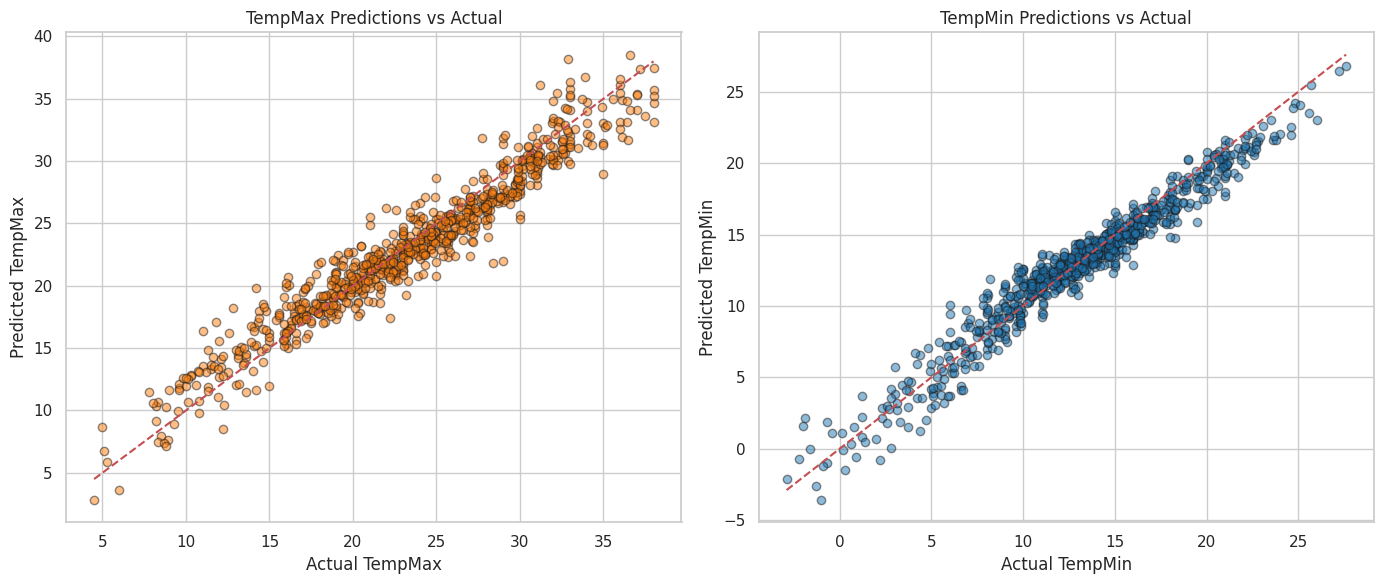

In [45]:
# Plot Actual vs Predicted values for TempMax and TempMin
plt.figure(figsize=(14, 6))

# Scatter plot for TempMax
plt.subplot(1, 2, 1)
plt.scatter(y_test_max, y_pred_test_max, alpha=0.5, color=color_pal[1], edgecolors='k')
plt.plot([y_test_max.min(), y_test_max.max()], [y_test_max.min(), y_test_max.max()], 'r--')
plt.xlabel('Actual TempMax')
plt.ylabel('Predicted TempMax')
plt.title('TempMax Predictions vs Actual')

# Scatter plot for TempMin
plt.subplot(1, 2, 2)
plt.scatter(y_test_min, y_pred_test_min, alpha=0.5, color=color_pal[0], edgecolors='k')
plt.plot([y_test_min.min(), y_test_min.max()], [y_test_min.min(), y_test_min.max()], 'r--')
plt.xlabel('Actual TempMin')
plt.ylabel('Predicted TempMin')
plt.title('TempMin Predictions vs Actual')

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
<b>Success!</b> The models are very accurate; there’s a strong correlation between the model’s predictions and its actual results. 
</div>

## Key Takeaways
- **Ridge Regression Performance:** The model demonstrates strong predictive power, with R² values of 0.9278 for TempMax and 0.9484 for TempMin, indicating a high level of accuracy. The low RMSE values further confirm effective temperature predictions.
- **Residual Analysis:** Analysis shows some autocorrelation, suggesting potential for model refinement and optimization.
- **Model Robustness:** Visualizations confirm that residuals are fairly normally distributed, highlighting the model's capability to handle multicollinearity and apply effective regularization.

**In summary**, the models perform well and are suitable for deployment. Addressing detected heteroskedasticity and autocorrelation could further enhance model robustness and reliability.

### Next Steps Could Include
1. **Model Serialization:** Serialize the TempMax and TempMin Ridge regression models using joblib or pickle for easy deployment.
2. **API Development:** Develop a RESTful API using Flask or FastAPI to enable easy access to the prediction models for various applications.
3. **Real-Time Data Integration:** Connect to live weather data sources and set up automated pipelines for continuous model updates.
4. **User Interface (UI) Design:** Build a web-based dashboard using frameworks like Dash or Streamlit for interactive predictions and insights.
5. **Performance Monitoring:** Implement monitoring tools to track model performance over time, detecting potential drifts or changes in data patterns.
6. **Comprehensive Documentation:** Create detailed documentation, including API usage, data requirements, and a user guide for ease of integration and use.
7. **Thorough Testing:** Perform extensive testing, including unit, integration, and user acceptance testing, to ensure the system's reliability and robustness.



# That's it! Thanks for joining me on this project. 
### Wanna simplify your data? Text me on [LinkedIn](https://www.linkedin.com/in/sof-code/)